In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from src.fraud import preproc, trimvars, model_summary,output_threshold
pd.options.display.float_format = '{:.3f}'.format

In [2]:
raw = pd.read_json('data/data.json')
raw['fraud'] = raw.acct_type.apply(lambda x: ('fraud' in x)*1)
df = preproc(raw)
trim = trimvars(df,'fraud','object_id')
df = df[trim]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 32 columns):
fraud                 14337 non-null int64
has_analytics         14337 non-null int64
has_logo              14337 non-null int64
fb_published          14337 non-null int64
name_length           14337 non-null int64
user_age              14337 non-null int64
A1                    14337 non-null uint8
AU                    14337 non-null uint8
CA                    14337 non-null uint8
CH                    14337 non-null uint8
CI                    14337 non-null uint8
CZ                    14337 non-null uint8
DZ                    14337 non-null uint8
GB                    14337 non-null uint8
ID                    14337 non-null uint8
KH                    14337 non-null uint8
MA                    14337 non-null uint8
NG                    14337 non-null uint8
PH                    14337 non-null uint8
PK                    14337 non-null uint8
US                    14337 non

In [3]:
target = 'fraud'
id_col = 'object_id'
X = df.drop('fraud',axis=1)
y = df[['fraud','object_id']]
print('Total: ',len(df))
print('Fraud Rate: ', df.fraud.sum()/len(df))

Total:  14337
Fraud Rate:  0.09018623142916929


In [4]:
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X,y,test_size=.3,random_state=29)
X_train = X_train_og.drop(id_col,axis=1)
X_test = X_test_og.drop(id_col,axis=1)
y_train = y_train_og.drop(id_col,axis=1)
y_test = y_test_og.drop(id_col,axis=1)
train = df.copy()
train.describe()

,fraud,has_analytics,has_logo,fb_published,name_length,user_age,A1,AU,CA,CH,...,user_1,user_3,user_4,body_0,duration,cost min,cost max,quantity_total sum,ticket_tiers_num,object_id
count,14337.000,14337.000,14337.000,14337.000,14337.000,14337.000,14337.000,14337.000,14337.000,14337.000,...,14337.000,14337.000,14337.000,14337.000,14337.000,14337.000,14337.000,14337.000,14337.000,14337.000
mean,0.090,0.073,0.842,0.127,41.629,374.227,0.002,0.052,0.088,0.000,...,0.261,0.525,0.210,0.058,0.103,67.161,191.936,6850.337,2.694,4531344.364
std,0.286,0.260,0.365,0.333,23.158,418.594,0.042,0.222,0.283,0.020,...,0.439,0.499,0.408,0.233,0.305,287.004,1373.360,337145.229,3.840,1987660.639
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,-1.160,0.000,0.000,0.000,47146.000
25%,0.000,0.000,1.000,0.000,26.000,13.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,4.000,15.000,36.000,1.000,2902989.000
50%,0.000,0.000,1.000,0.000,38.000,242.000,0.000,0.000,0.000,0.000,...,0.000,1.000,0.000,0.000,0.000,17.500,32.080,100.000,2.000,4580386.000
75%,0.000,0.000,1.000,0.000,53.000,603.000,0.000,0.000,0.000,0.000,...,1.000,1.000,0.000,0.000,0.000,45.000,93.510,300.000,3.000,6073577.000
max,1.000,1.000,1.000,1.000,254.000,3794.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,15989.800,100000.000,30500000.000,116.000,8792893.000


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [6]:
#create our models
gbc = GradientBoostingClassifier(n_estimators=200,
                                  learning_rate=.05, 
                                  validation_fraction=0.1,     #Use 10% of the data for internal validation
                                  n_iter_no_change=3,          #Stop Iterating if there is no improvement within 3 iterations
                                  max_depth=3, 
                                  subsample=.9,                #Train only using 90% of the dataset each iteration
                                  random_state=29)             #Random Seed
gbc.fit(X_train,y_train)

ab = AdaBoostClassifier(n_estimators=200,random_state=29,
                            learning_rate=.01)
ab.fit(X_train,y_train)

br = BaggingClassifier(n_estimators=200,
                       n_jobs=-1,
                       max_samples=.9,
                       random_state=29)
br.fit(X_train,y_train)

dt = DecisionTreeClassifier(max_depth=3,random_state=29)
dt.fit(X_train,y_train)

rf = RandomForestClassifier(n_estimators=1000,
                            max_depth=3,
                            random_state=29,
                            n_jobs=-1)
rf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example u

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=29, verbose=0,
                       warm_start=False)

In [7]:
# The Gradient Boosted model by itself
y_pred_gb = gbc.predict_proba(X_test)[:,1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)

# The Random Forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# The AdaBoost model by itself
y_pred_ab = ab.predict_proba(X_test)[:,1]
fpr_ab, tpr_ab, _ = roc_curve(y_test, y_pred_ab)

# The Bagging model by itself
y_pred_br = br.predict_proba(X_test)[:,1]
fpr_br, tpr_br, _ = roc_curve(y_test, y_pred_br)

# The Decision Tree model by itself
y_pred_dt = dt.predict_proba(X_test)[:,1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)

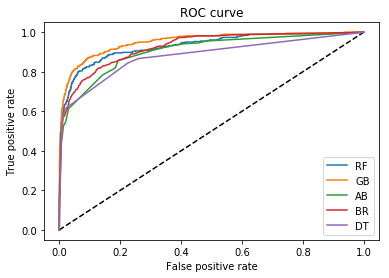

In [39]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gb, tpr_gb, label='GB')
plt.plot(fpr_ab, tpr_ab, label='AB')
plt.plot(fpr_br, tpr_br, label='BR')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Number of Trees:  198

Model Report
Accuracy : 0.9563
AUC Score (Train): 0.952010



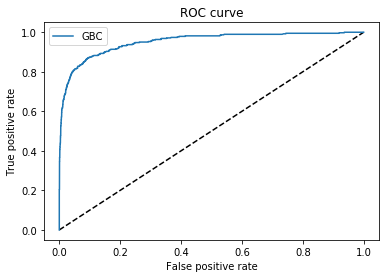

[[3889   30]
 [ 158  225]]

CV Score : Mean - 0.9636 | Std - 0.0018656 | Min - 0.96144 | Max - 0.96597
Optimal Threshold: 0.06241


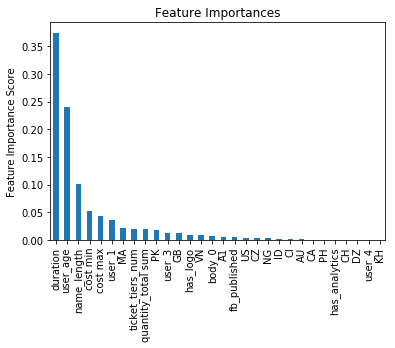

In [9]:
# See how many iterations it took to learn
print("Number of Trees: ",gbc.n_estimators_)

pred1,thresh1,ft1 = model_summary(train,target,id_col,X_test,y_test,gbc)

In [10]:
ft1

duration             0.374
user_age             0.241
name_length          0.101
cost min             0.051
cost max             0.044
user_1               0.037
MA                   0.021
ticket_tiers_num     0.019
quantity_total sum   0.019
PK                   0.018
user_3               0.012
GB                   0.012
has_logo             0.010
VN                   0.009
body_0               0.007
A1                   0.005
fb_published         0.005
US                   0.004
CZ                   0.004
NG                   0.003
ID                   0.002
CI                   0.001
AU                   0.001
CA                   0.000
PH                   0.000
has_analytics        0.000
CH                   0.000
DZ                   0.000
user_4               0.000
KH                   0.000
dtype: float64

In [16]:
output_threshold(y_test, pred1,threshold=.062)
average_precision_score(y_test, pred1)

Precision: 0.48
Recall: 0.87
Accuracy: 0.90
AUC: 0.952

Threshold: 0.062

% of true positives: 0.869
% Engaged: 0.162
% of TP in Engaged pop: 0.476


[[3553  366]
 [  50  333]]


0.8065761343544046

In [35]:
output_threshold(y_test, pred1,threshold=.6)
average_precision_score(y_test, pred1)

Precision: 0.91
Recall: 0.52
Accuracy: 0.95
AUC: 0.952

Threshold: 0.600

% of true positives: 0.522
% Engaged: 0.051
% of TP in Engaged pop: 0.913


[[3900   19]
 [ 183  200]]


0.8065761343544046

In [24]:
results_ranked = []
for i in range(len(pred1)):
    if pred1[i] >= 0.6:
        results_ranked.append('High Risk')
    elif pred1[i] >= .062:
        results_ranked.append('Medium Risk')
    else:
        results_ranked.append('Low Risk')

In [25]:
check = pd.DataFrame(results_ranked)
check = pd.concat([check,pd.Series(pred1)],axis=1)
check = pd.concat([check,y_test.reset_index(drop=True)],axis=1)
check.columns = ['Score','Pred','Actual']
check.Score.value_counts()

Low Risk       3603
Medium Risk     480
High Risk       219
Name: Score, dtype: int64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


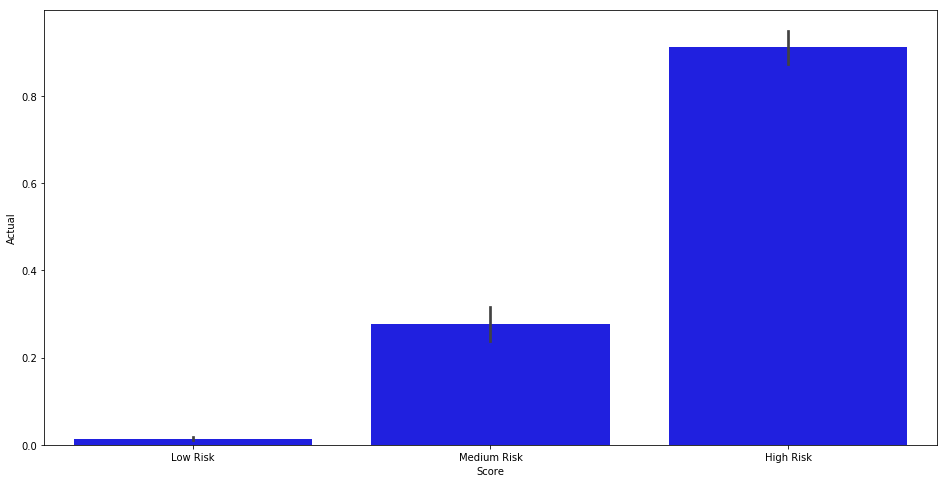

In [26]:
import seaborn as sns
fig = plt.figure(figsize=(16,8))
sns.barplot(check.Score,check.Actual,color='blue')

In [41]:
out = pd.merge(X_test_og,
               y_test_og,
               on = 'object_id')
out['preds'] = pred1
out.to_csv('data/fraudify.csv',index=False)